In [2]:
import numpy as np
import torch
from deep_parity.boolean_cube import generate_all_binary_arrays, fourier_transform
import polars as pl

from plotnine import ggplot, aes, geom_line, geom_bar, geom_histogram, facet_wrap

In [3]:
import numpy as np
import torch
from itertools import combinations

def generate_all_binary_arrays(n: int):
    numbers = np.arange(2**n, dtype=np.uint32)
    return ((numbers[:, np.newaxis] >> np.arange(n)[::-1]) & 1).astype(np.uint8)

def fourier_transform(u, normalize=True):
    _, n = u.shape
    m = int(np.log2(n))
    assert n == 1 << m, 'n must be a power of 2'
    x = u[..., np.newaxis]
    for _ in range(m)[::-1]:
        x = torch.cat((x[..., ::2, :] + x[..., 1::2, :], x[..., ::2, :] - x[..., 1::2, :]), dim=-1)
    return x.squeeze(-2) / 2**(m / 2) if normalize else x.squeeze(-2)

def generate_random_degree_11_function(n=18, degree=11, distribution='gaussian', scale=1.0):
    """
    Generate a random function on {-1, 1}^n that depends only on degree 11 terms.
    
    Parameters:
    n (int): Dimension of the boolean cube (default: 18)
    degree (int): Degree of the terms to consider (default: 11)
    distribution (str): Type of random distribution to use ('gaussian' or 'uniform')
    scale (float): Scale factor for the random numbers
    
    Returns:
    torch.Tensor: The generated function values on {-1, 1}^n
    """
    # Create a vector of zeros
    fourier_coeffs = torch.zeros(2**n)
    
    # Generate indices for degree 11 terms
    degree_11_indices = []
    for comb in combinations(range(n), degree):
        index = sum(2**i for i in comb)
        degree_11_indices.append(index)
    
    # Generate random numbers for degree 11 terms
    num_coeffs = len(degree_11_indices)
    if distribution == 'gaussian':
        random_coeffs = torch.randn(num_coeffs) * scale
    elif distribution == 'uniform':
        random_coeffs = (torch.rand(num_coeffs) * 2 - 1) * scale
    else:
        raise ValueError("Distribution must be 'gaussian' or 'uniform'")
    
    # Assign random numbers to degree 11 indices
    fourier_coeffs[degree_11_indices] = random_coeffs
    
    # Perform inverse Fourier transform
    function_values = fourier_transform(fourier_coeffs.unsqueeze(0)).squeeze(0)
    
    return function_values

# Example usage
n = 18
degree = 11
random_function = generate_random_degree_11_function(n, degree, distribution='uniform', scale=1.0)

print(f"Generated function on {{-1, 1}}^{n} with {degree}-degree terms:")
print(f"Shape of the function: {random_function.shape}")
print(f"First 10 values: {random_function[:10]}")
print(f"Last 10 values: {random_function[-10:]}")

Generated function on {-1, 1}^18 with 11-degree terms:
Shape of the function: torch.Size([262144])
First 10 values: tensor([ 0.1535,  0.0797, -0.1551, -0.0177, -0.4397,  0.1637,  0.3438, -0.2628,
        -0.3814,  0.3127])
Last 10 values: tensor([-0.3127,  0.3814,  0.2628, -0.3438, -0.1637,  0.4397,  0.0177,  0.1551,
        -0.0797, -0.1535])


tensor([[ 1.,  1.,  1.,  1.],
        [-1., -1.,  1.,  1.],
        [ 1.,  1., -1.,  1.],
        [ 1., -1., -1., -1.]])

In [116]:
def rademacher(shape):
    return torch.sign(torch.bernoulli(torch.full(shape, 0.5)) -.5)


n = 8
small_cube = torch.from_numpy(-1. * np.sign(generate_all_binary_arrays(n).astype(np.float32) - 0.5))

In [183]:
w = torch.ones(8)

f = (small_cube @ w).unsqueeze(0)

fourier_transform((f + f.abs())/2)


tensor([[17.5000,  8.0000,  8.0000,  2.5000,  8.0000,  2.5000,  2.5000,  0.0000,
          8.0000,  2.5000,  2.5000,  0.0000,  2.5000,  0.0000,  0.0000, -0.5000,
          8.0000,  2.5000,  2.5000,  0.0000,  2.5000,  0.0000,  0.0000, -0.5000,
          2.5000,  0.0000,  0.0000, -0.5000,  0.0000, -0.5000, -0.5000,  0.0000,
          8.0000,  2.5000,  2.5000,  0.0000,  2.5000,  0.0000,  0.0000, -0.5000,
          2.5000,  0.0000,  0.0000, -0.5000,  0.0000, -0.5000, -0.5000,  0.0000,
          2.5000,  0.0000,  0.0000, -0.5000,  0.0000, -0.5000, -0.5000,  0.0000,
          0.0000, -0.5000, -0.5000,  0.0000, -0.5000,  0.0000,  0.0000,  0.5000,
          8.0000,  2.5000,  2.5000,  0.0000,  2.5000,  0.0000,  0.0000, -0.5000,
          2.5000,  0.0000,  0.0000, -0.5000,  0.0000, -0.5000, -0.5000,  0.0000,
          2.5000,  0.0000,  0.0000, -0.5000,  0.0000, -0.5000, -0.5000,  0.0000,
          0.0000, -0.5000, -0.5000,  0.0000, -0.5000,  0.0000,  0.0000,  0.5000,
          2.5000,  0.0000,  

In [184]:
fourier_transform(relu(f))

tensor([[17.5000,  8.0000,  8.0000,  2.5000,  8.0000,  2.5000,  2.5000,  0.0000,
          8.0000,  2.5000,  2.5000,  0.0000,  2.5000,  0.0000,  0.0000, -0.5000,
          8.0000,  2.5000,  2.5000,  0.0000,  2.5000,  0.0000,  0.0000, -0.5000,
          2.5000,  0.0000,  0.0000, -0.5000,  0.0000, -0.5000, -0.5000,  0.0000,
          8.0000,  2.5000,  2.5000,  0.0000,  2.5000,  0.0000,  0.0000, -0.5000,
          2.5000,  0.0000,  0.0000, -0.5000,  0.0000, -0.5000, -0.5000,  0.0000,
          2.5000,  0.0000,  0.0000, -0.5000,  0.0000, -0.5000, -0.5000,  0.0000,
          0.0000, -0.5000, -0.5000,  0.0000, -0.5000,  0.0000,  0.0000,  0.5000,
          8.0000,  2.5000,  2.5000,  0.0000,  2.5000,  0.0000,  0.0000, -0.5000,
          2.5000,  0.0000,  0.0000, -0.5000,  0.0000, -0.5000, -0.5000,  0.0000,
          2.5000,  0.0000,  0.0000, -0.5000,  0.0000, -0.5000, -0.5000,  0.0000,
          0.0000, -0.5000, -0.5000,  0.0000, -0.5000,  0.0000,  0.0000,  0.5000,
          2.5000,  0.0000,  

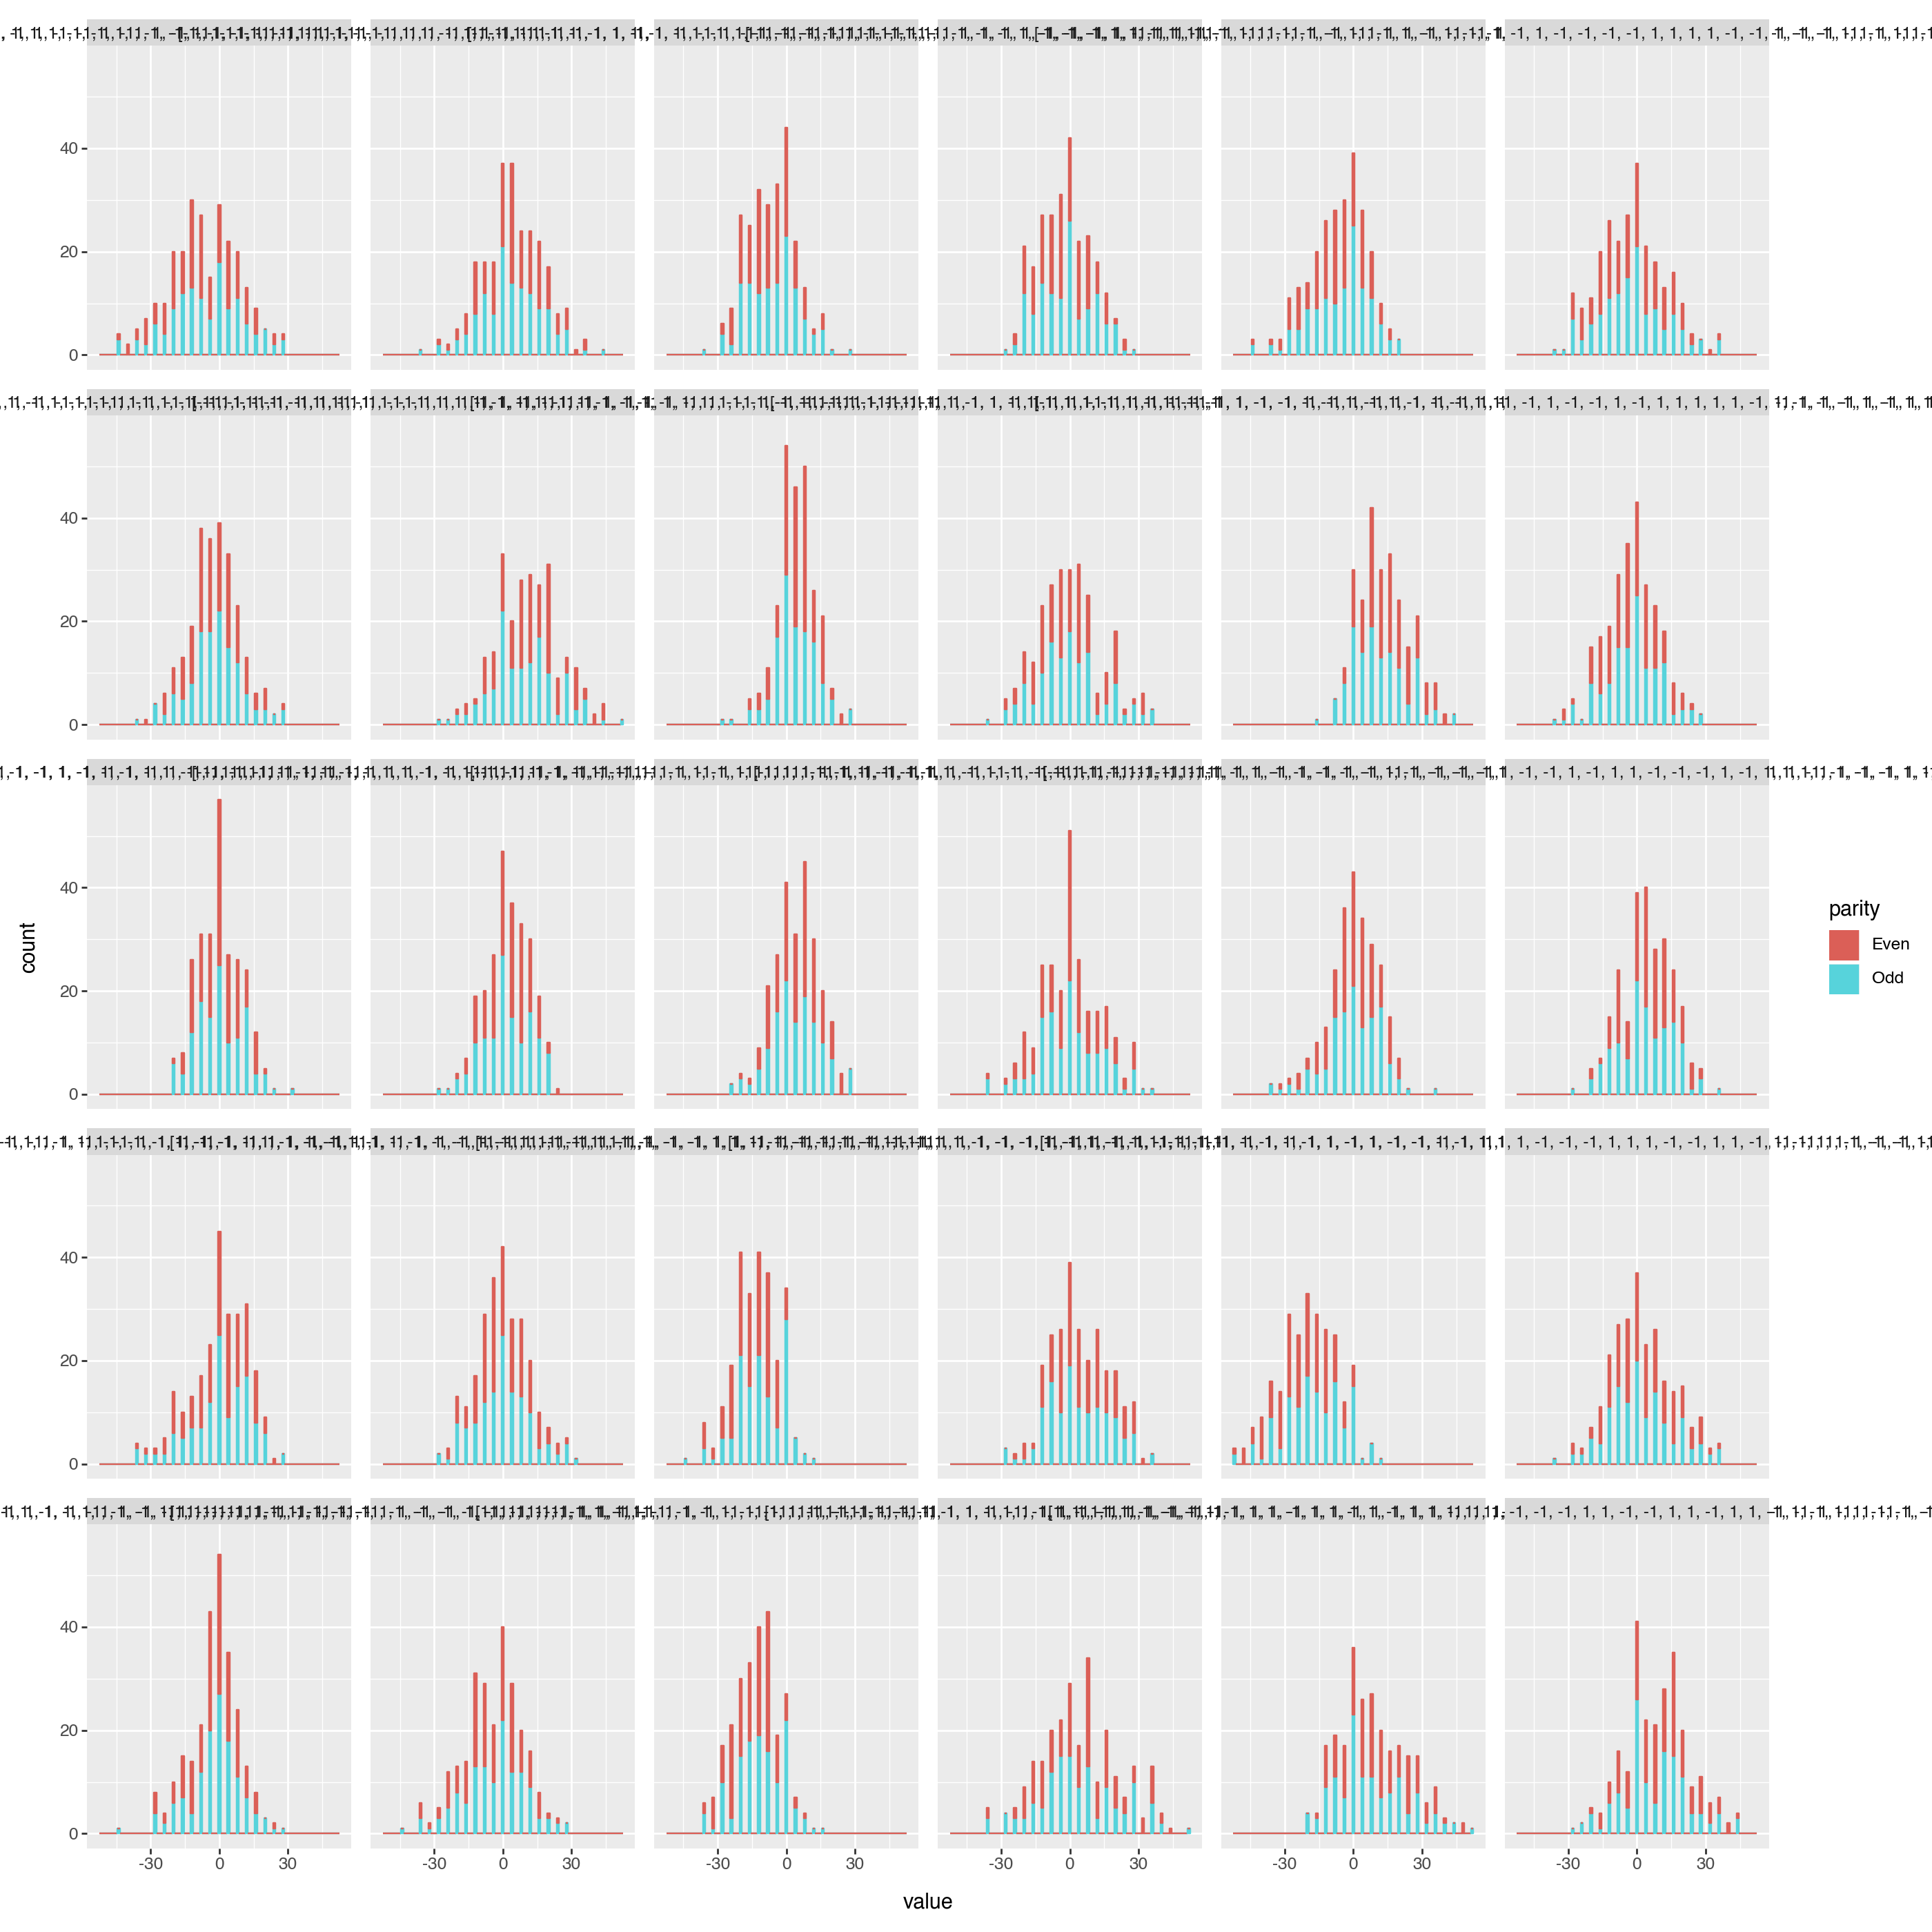

In [176]:
from torch.nn.functional import relu
from plotnine import theme, geom_density

def parity(x):
    match x:
        case 1:
            return 'Even'
        case -1:
            return 'Odd'
        case _:
            raise ValueError('Must be 1 or -1')



num_neurons = rand_majority.shape[0]
# shape (2**num_neurons, num_neurons)
contractions = rademacher((30, num_neurons))
# shape(2**n, num_neurons)
layer_outs =  relu(small_cube @ rand_majority.T)

# (2**n, 2**num_neurons)
possible_logits = layer_outs @ contractions.T

data = {str(sign_pattern.to(int).tolist()): logits.numpy() for sign_pattern, logits in zip(contractions, possible_logits.T)}
data.update({
    'degree': (small_cube == -1).sum(dim=1).numpy(),
    'parity': [parity(int(x.item())) for x in small_cube.prod(dim=1)],
})




df = pl.DataFrame(data).unpivot(index=['degree', 'parity'])

(
    ggplot(df, aes(x='value', color='parity', fill='parity'))
    + geom_histogram(binwidth=1)
    + facet_wrap('~variable')
    + theme(figure_size=(14, 14))
)

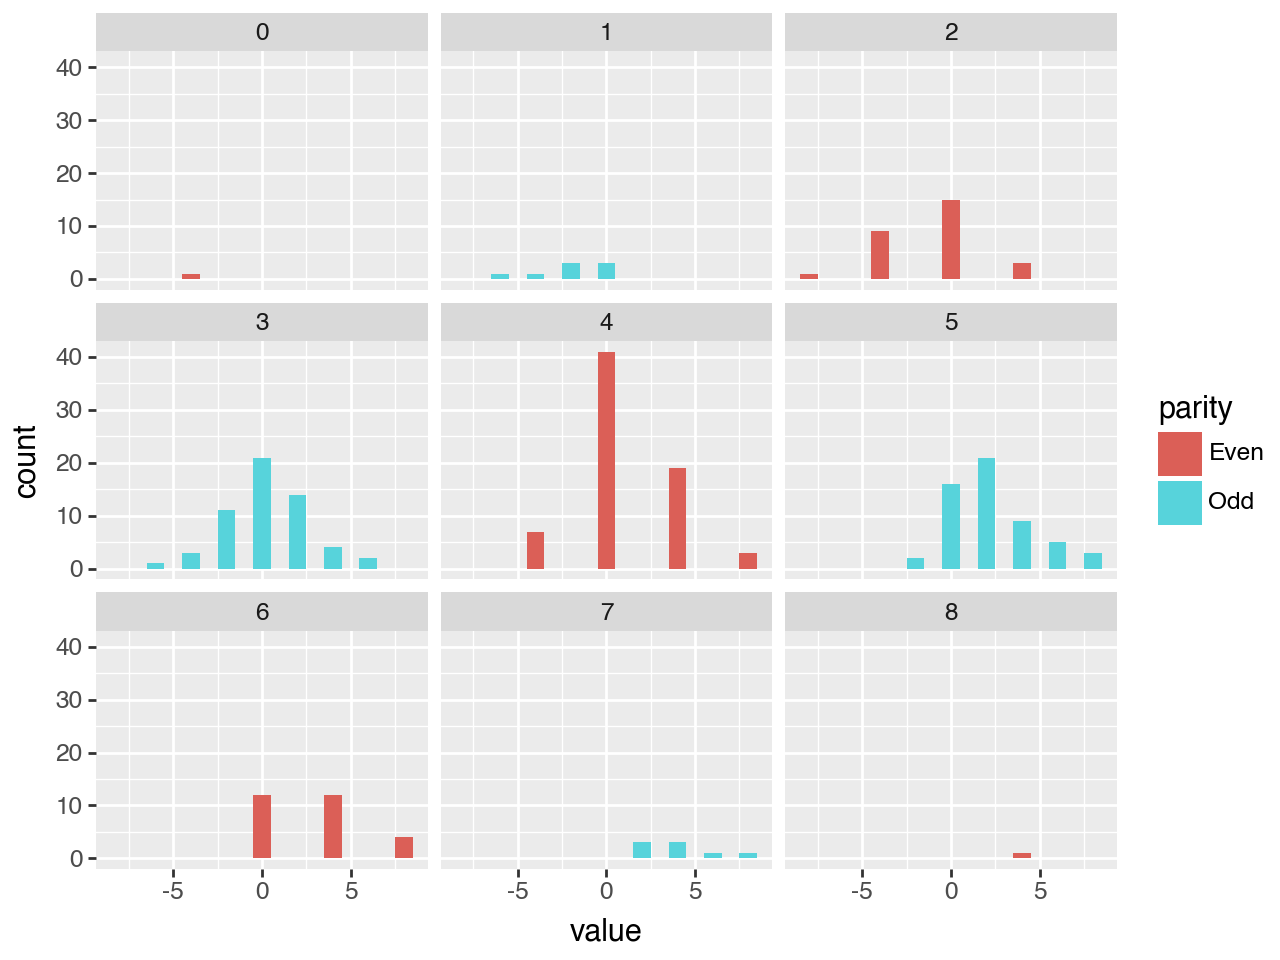

In [124]:
ggplot(df.filter(pl.col('variable').eq('[-1, 1, 1]')), aes(x='value', fill='parity')) + geom_histogram(binwidth=1) + facet_wrap('~degree')

In [125]:
from plotnine import geom_point
raw_data = {f'n{i}': outs.numpy() for i, outs in zip(range(num_neurons), layer_outs.T)}
raw_data.update({
    'degree': (small_cube == -1).sum(dim=1).numpy(),
    'parity': [parity(int(x.item())) for x in small_cube.prod(dim=1)],
})

raw_df = pl.DataFrame(raw_data)

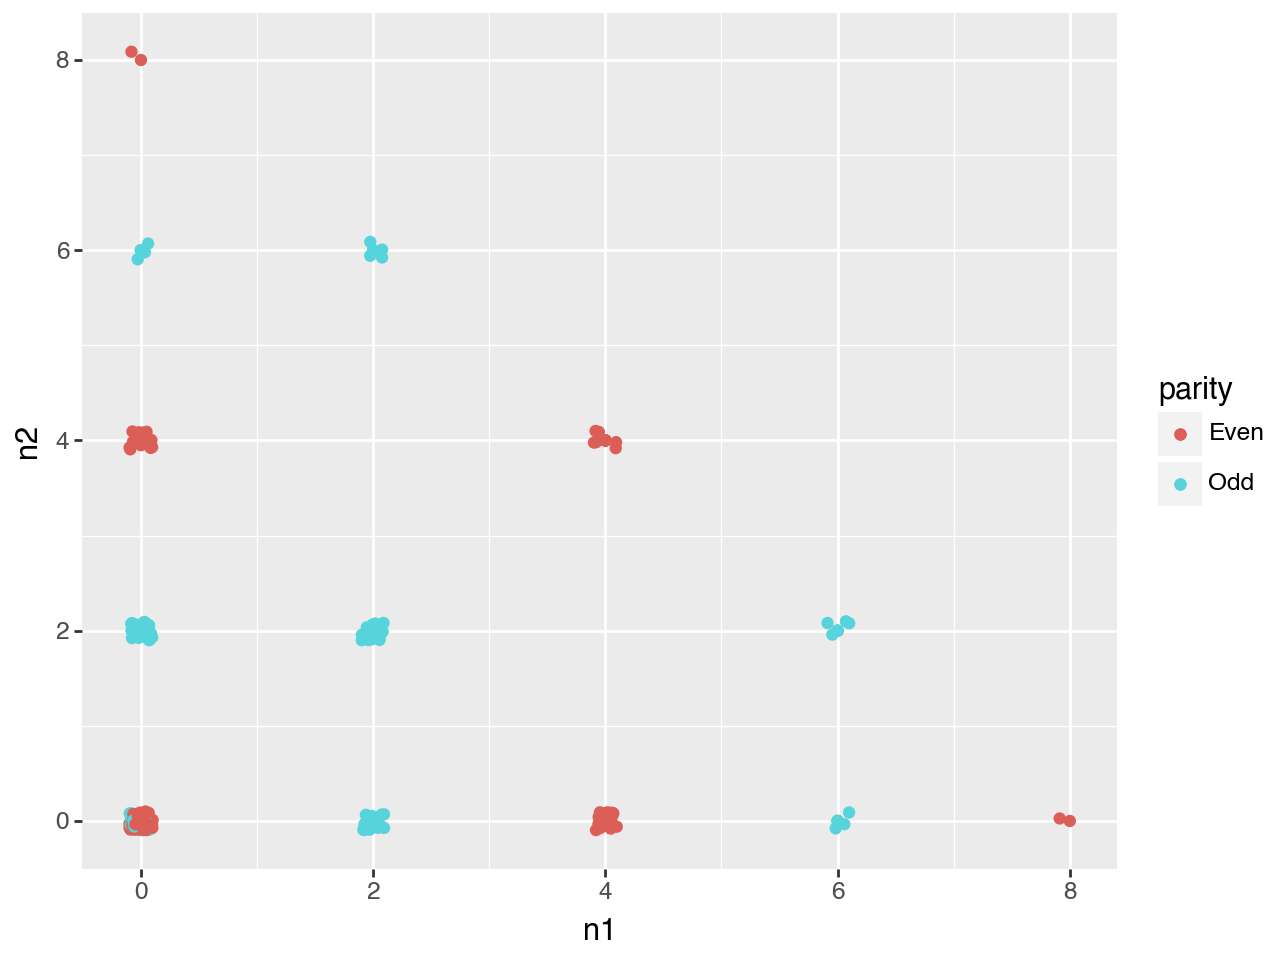

In [132]:
from plotnine import geom_jitter

ggplot(raw_df, aes(x='n1', y='n2', color='parity')) + geom_point() + geom_jitter(width=0.1, height=0.1)

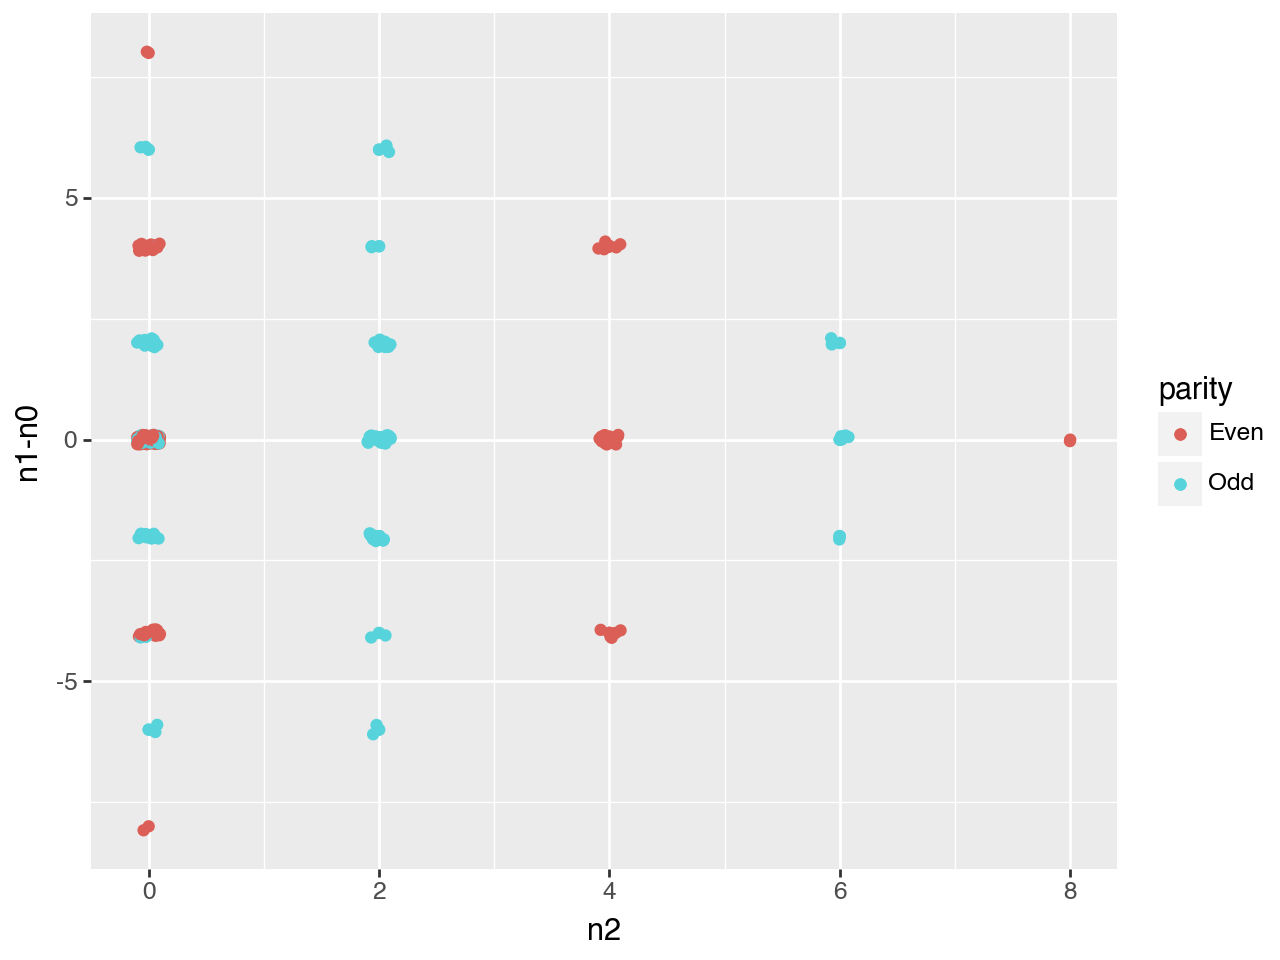

In [130]:
ggplot(raw_df, aes(x='n2', y='n1-n0', color='parity')) + geom_point() + geom_jitter(width=0.1, height=0.1)

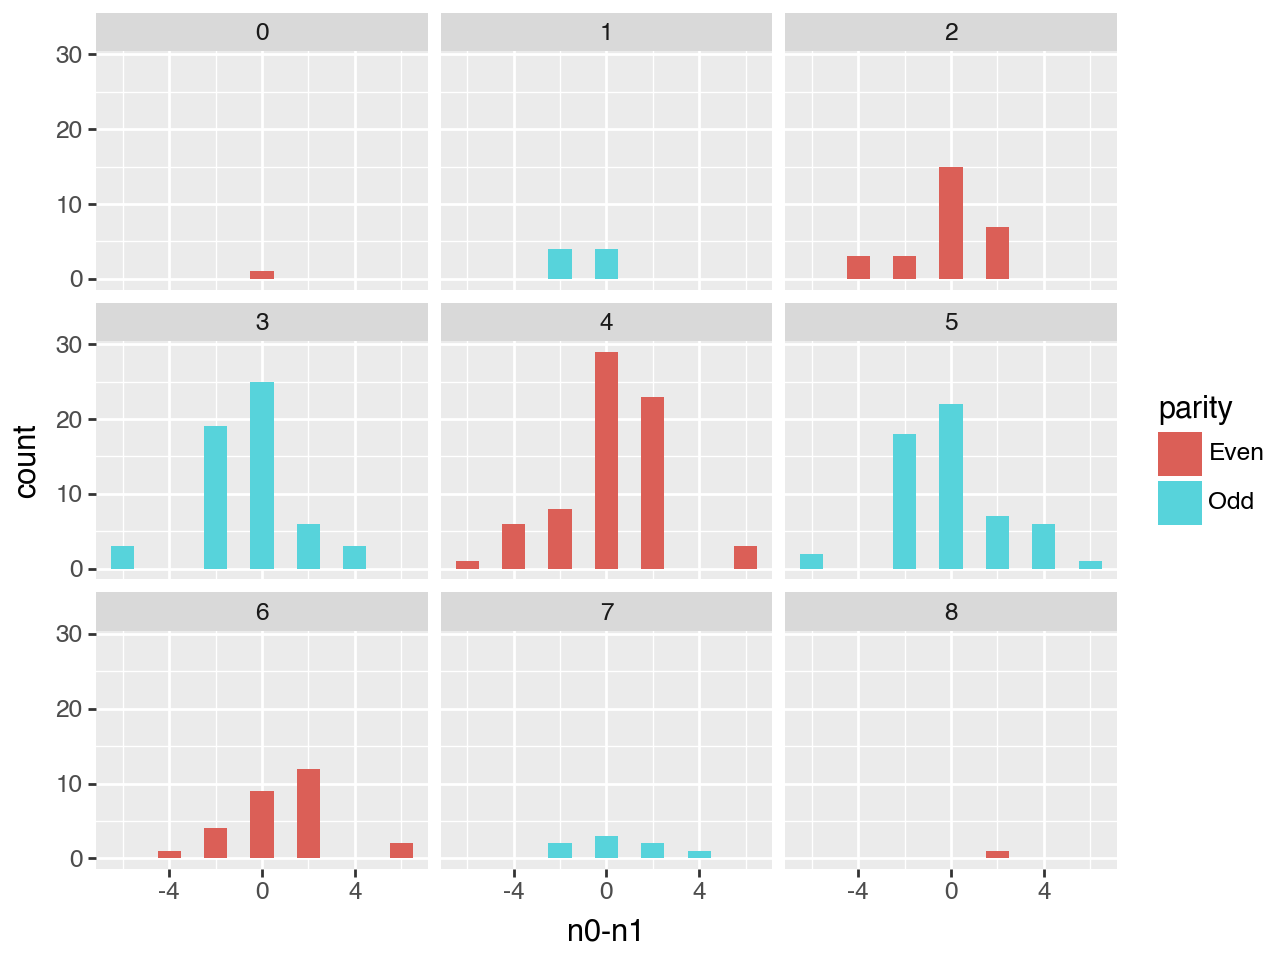

In [108]:
ggplot(raw_df, aes(x='n0-n1', fill='parity')) + geom_histogram(binwidth=1) + facet_wrap('~degree')

In [6]:
import polars as pl

def make_base_parity_dataframe(n):
    all_binary_data = generate_all_binary_arrays(n)
    all_degrees = all_binary_data.sum(axis=1)
    all_parities = all_degrees % 2
    base_df = pl.DataFrame({
        'bits': all_binary_data, 
        'parities': all_parities, 
        'degree': all_degrees
    })
    base_df = base_df.with_columns(
        indices=pl.col('bits').arr.to_list().list.eval(pl.arg_where(pl.element() == 1))
    )
    return base_df

boolean_df = make_base_parity_dataframe(n)

In [23]:
rand_df = boolean_df.with_columns(rand_fn = pl.Series(random_function.numpy()))

/Users/dashiell/workspace/deep-parity/.venv/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 211'. Pick better value with 'binwidth'.


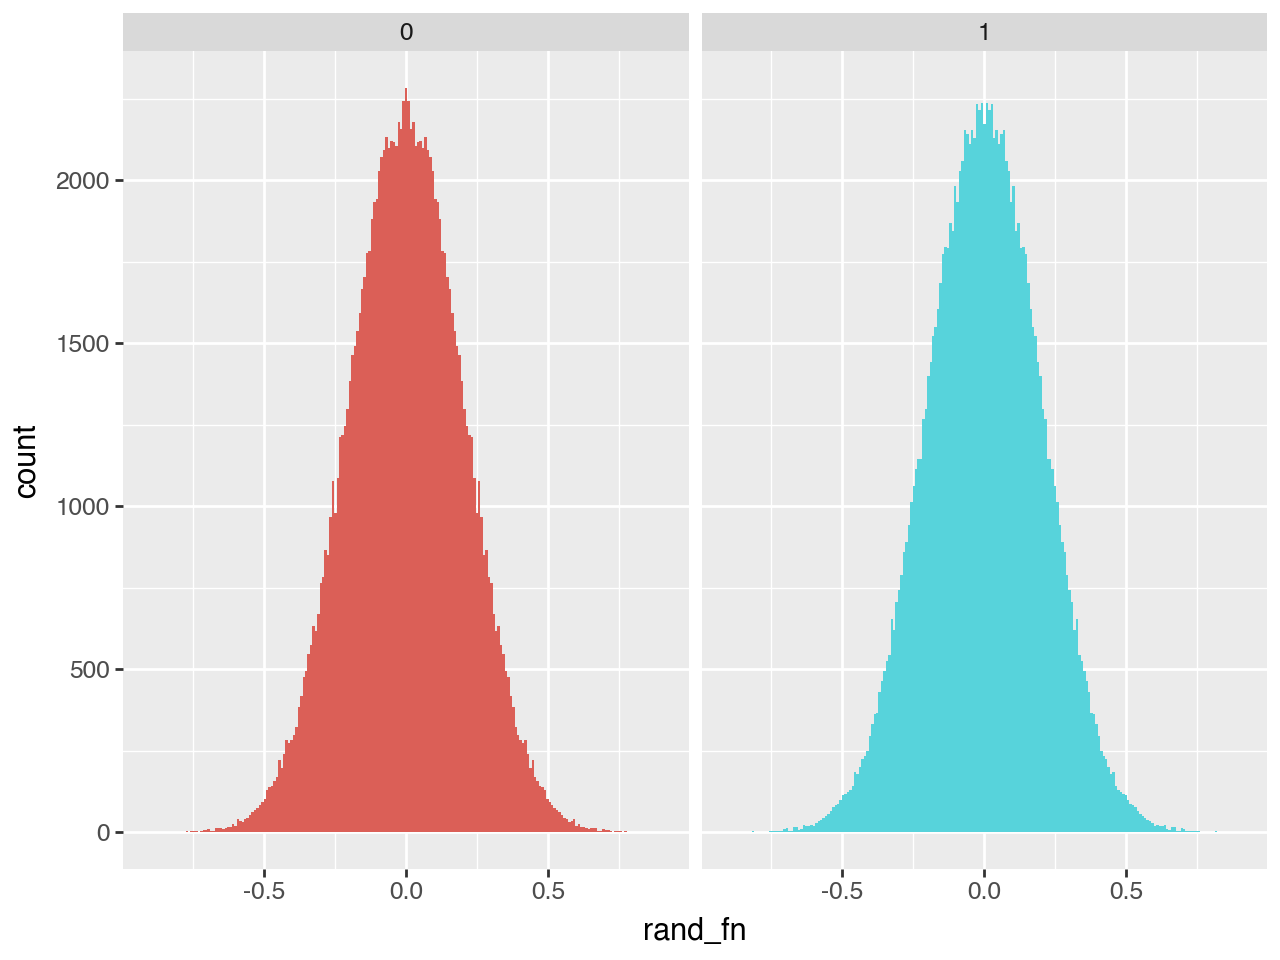

In [24]:
ggplot(rand_df, aes(x='rand_fn', fill='factor(parities)')) + geom_histogram(show_legend=False) + facet_wrap('~parities')

In [3]:
from torch.nn.functional import relu

def _rlf(weights, vals):
    return relu(weights @ vals.T)


In [4]:
rlf = torch.vmap(_rlf, in_dims=(0, None))

In [5]:
weights = torch.from_numpy(generate_all_binary_arrays(n)).to(torch.float64)
weights = torch.sign((-1 * weights) + 0.5)

In [6]:
rand_vals = rlf(weights, all_bn)

In [7]:
ft = fourier_transform(rand_vals, n)

In [8]:
def make_base_parity_dataframe(n):
    all_binary_data = generate_all_binary_arrays(n)
    all_degrees = all_binary_data.sum(axis=1)
    all_parities = all_degrees % 2
    base_df = pl.DataFrame({
        'bits': all_binary_data, 
        'parities': all_parities, 
        'degree': all_degrees
    })
    base_df = base_df.with_columns(
        indices=pl.col('bits').arr.to_list().list.eval(pl.arg_where(pl.element() == 1))
    )
    return base_df


def calc_power_contributions(tensor, n, epoch):
    linear_dim = tensor.shape[1]
    base_df = make_base_parity_dataframe(n)
    ft = fourier_transform(tensor.T.to('cuda'))
    ft /= ft.mean(dim=0, keepdims=True)
    linear_df = pl.DataFrame(
        ft.T.detach().cpu().numpy(),
        schema=[str(i) for i in range(linear_dim)]
    )
    data = pl.concat([base_df, linear_df], how='horizontal')
    total_power = (
        data
        .select(pl.exclude('bits', 'parities', 'indices', 'degree'))
        .unpivot()
        .with_columns(pl.col('variable').str.to_integer())
        .group_by('variable').agg(pl.col('value').pow(2).sum())
        .rename({'value': 'power'})
    )
    power_df = (
        data
        .select(pl.exclude('bits', 'parities', 'indices'))
        .unpivot(index='degree')
        .with_columns(pl.col('variable').str.to_integer())
        .group_by('degree', 'variable').agg(pl.col('value').pow(2).sum())
        .join(total_power, on='variable', how='left')
        .with_columns(pcnt_power = pl.col('value') / pl.col('power'), epoch=pl.lit(epoch))
    )
    return power_df

boolean_df = make_base_parity_dataframe(n)

In [12]:
ft_df = pl.DataFrame({str(i): vals.squeeze().numpy() for i, vals in enumerate(ft.split(1))})
data = (
    pl.concat([boolean_df, ft_df], how='horizontal')
    .unpivot(index=['bits', 'parities', 'degree', 'indices'])
    .with_columns(pl.col('variable').str.to_integer())
)
data.head()

bits,parities,degree,indices,variable,value
"array[u8, 10]",u64,u64,list[u32],i64,f64
"[0, 0, … 0]",0,0,[],0,39.375
"[0, 0, … 1]",1,1,[9],0,16.0
"[0, 0, … 0]",1,1,[8],0,16.0
"[0, 0, … 1]",0,2,"[8, 9]",0,4.375
"[0, 0, … 0]",1,1,[7],0,16.0


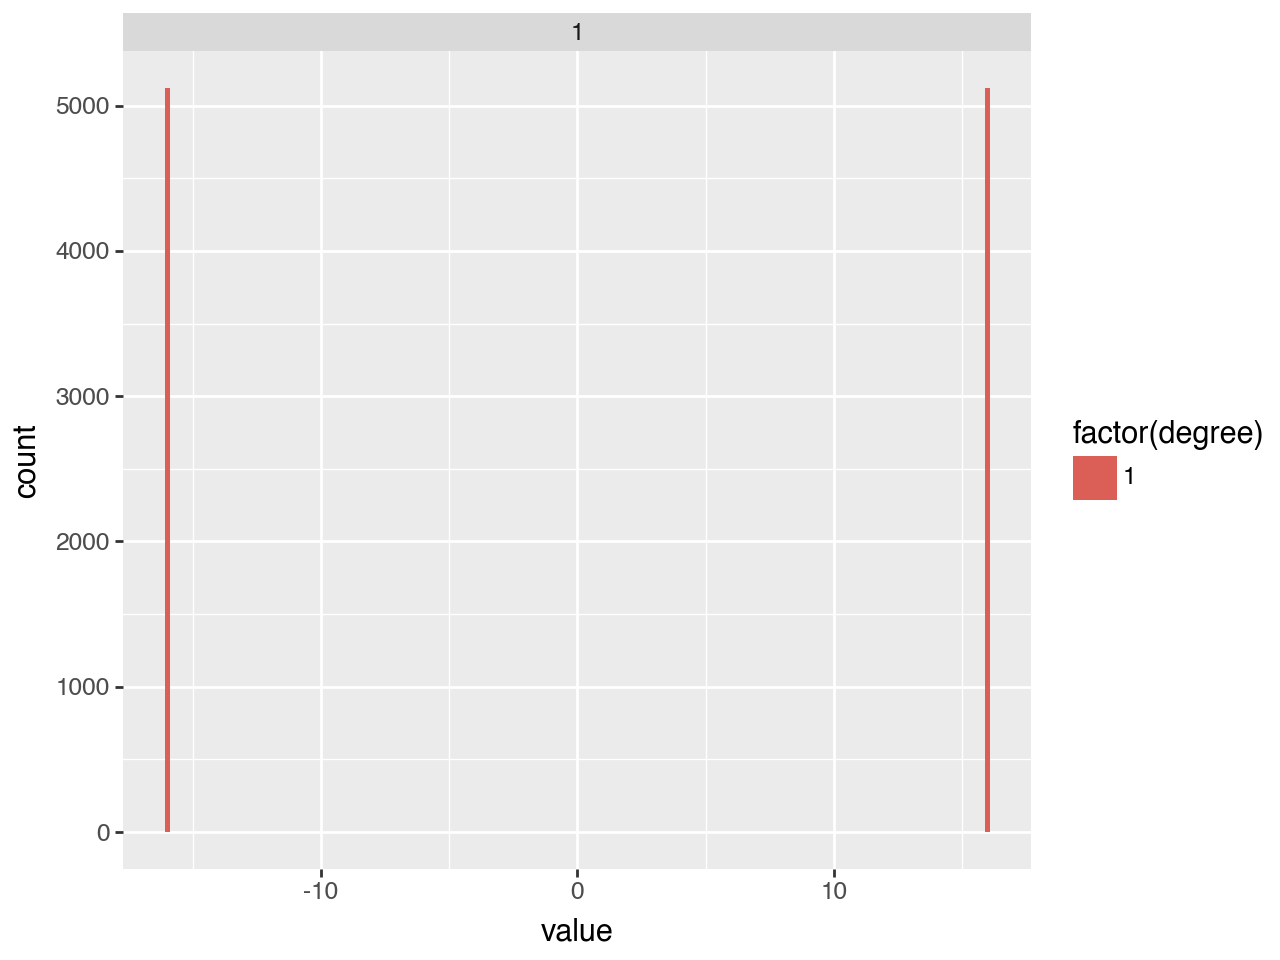

In [22]:
ggplot(data.filter(pl.col('degree').eq(1)), aes(x='value', fill='factor(degree)')) + geom_histogram(binwidth=0.2) + facet_wrap('~degree')

In [193]:
data.filter(pl.col('degree').eq(0) & pl.col('value').lt(0))

bits,parities,degree,indices,variable,value
"array[u8, 12]",u64,u64,list[u32],i64,f64
"[0, 0, … 0]",0,0,[],15,-0.875
"[0, 0, … 0]",0,0,[],23,-0.875
"[0, 0, … 0]",0,0,[],27,-0.875
"[0, 0, … 0]",0,0,[],29,-0.875
"[0, 0, … 0]",0,0,[],30,-0.875
…,…,…,…,…,…
"[0, 0, … 0]",0,0,[],4066,-0.375
"[0, 0, … 0]",0,0,[],4068,-0.375
"[0, 0, … 0]",0,0,[],4072,-0.375


Sum of analytical probabilities: 1.0000000000
Sum of simulated probabilities: 1.0000000000

Analytical mean: 0.0000, variance: 335.0000
Simulated mean: -0.0235, variance: 334.4949
Expected variance: 335.0000


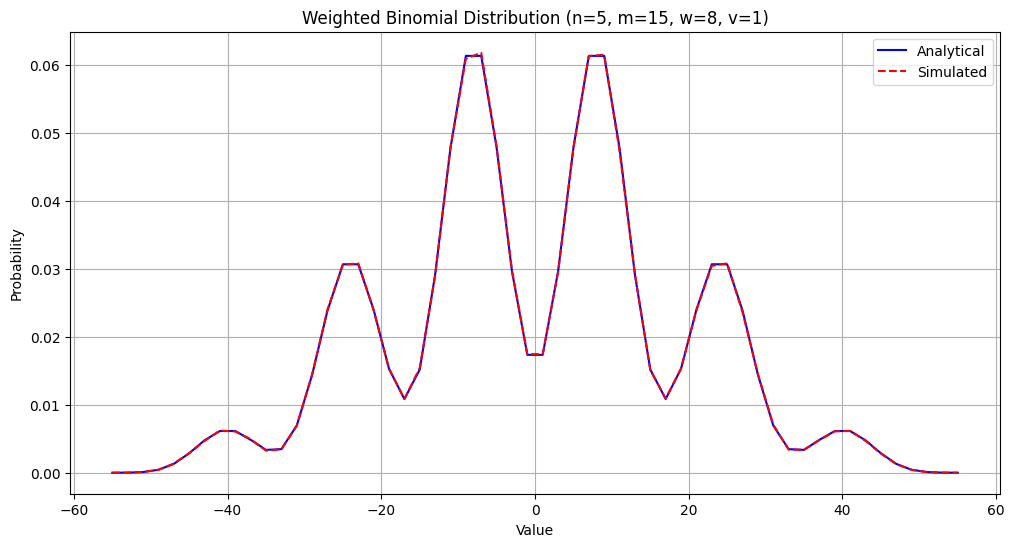

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def analytical_pmf(n, m, w, v):
    """
    Calculate the PMF of sum of two weighted binomials analytically
    n, m: number of trials for each binomial
    w, v: weights (any ratio)
    """
    # Create dictionary to store probabilities
    pmf = {}
    
    # Calculate support range
    k_min = -w*n - v*m
    k_max = w*n + v*m
    
    # For each possible value k
    for k in range(k_min, k_max + 1, v):
        prob = 0
        # The equation is now:
        # 2w*i + 2v*j = k + w*n + v*m
        # or: 2w*i + 2v*j = k + w*n + v*m
        
        # For each possible i
        for i in range(n + 1):
            # Solve for j:
            # 2v*j = (k + w*n + v*m) - 2w*i
            j_val = (k + w*n + v*m - 2*w*i)/(2*v)
            
            # Check if j is integer and in valid range
            if j_val.is_integer() and 0 <= j_val <= m:
                j = int(j_val)
                # Add probability contribution
                prob += (
                    math.comb(n, i) * 
                    math.comb(m, j) / 
                    2**(n + m)
                )
        
        if prob > 0:
            pmf[k] = prob
            
    return pmf

def simulate_distribution(n, m, w, v, num_samples=100000):
    """
    Simulate the distribution through direct sampling
    """
    # Generate binomial samples
    x = np.random.binomial(n, 0.5, num_samples)
    y = np.random.binomial(m, 0.5, num_samples)
    
    # Convert to weighted differences
    z = w*(2*x - n) + v*(2*y - m)
    
    # Calculate empirical PMF
    counts = Counter(z)
    total = sum(counts.values())
    return {k: v/total for k, v in counts.items()}

# Test parameters
n, m = 5, 15
v = 1
w = 8

# Calculate analytical PMF
analytical = analytical_pmf(n, m, w, v)

# Simulate distribution
simulated = simulate_distribution(n, m, w, v, num_samples=1000000)

# Plot comparison
plt.figure(figsize=(12, 6))
k_values = sorted(set(analytical.keys()) | set(simulated.keys()))

plt.plot(k_values, [analytical.get(k, 0) for k in k_values], 'b-', label='Analytical')
plt.plot(k_values, [simulated.get(k, 0) for k in k_values], 'r--', label='Simulated')
plt.legend()
plt.grid(True)
plt.title(f'Weighted Binomial Distribution (n={n}, m={m}, w={w}, v={v})')
plt.xlabel('Value')
plt.ylabel('Probability')

# Print some validation statistics
total_analytical = sum(analytical.values())
total_simulated = sum(simulated.values())

print(f"Sum of analytical probabilities: {total_analytical:.10f}")
print(f"Sum of simulated probabilities: {total_simulated:.10f}")

# Calculate mean and variance both ways
def get_stats(pmf):
    mean = sum(k*p for k, p in pmf.items())
    var = sum(k*k*p for k, p in pmf.items()) - mean*mean
    return mean, var

mean_analytical, var_analytical = get_stats(analytical)
mean_simulated, var_simulated = get_stats(simulated)

print(f"\nAnalytical mean: {mean_analytical:.4f}, variance: {var_analytical:.4f}")
print(f"Simulated mean: {mean_simulated:.4f}, variance: {var_simulated:.4f}")
print(f"Expected variance: {w*w*n + v*v*m:.4f}")

Sum of analytical probabilities: 1.0000000000
Sum of simulated probabilities: 1.0000000000

Analytical mean: 0.0000, variance: 6850.0000
Simulated mean: 0.0360, variance: 6847.8616
Expected variance: 16200.0000


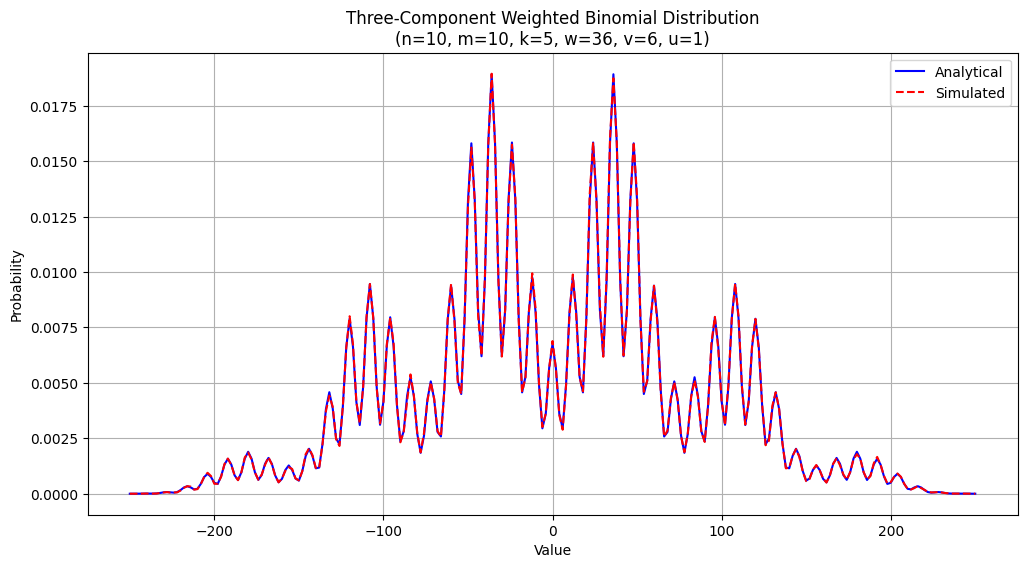

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def analytical_pmf_three(n, m, l, u, v, w):
    """
    Calculate the PMF of sum of three weighted binomials analytically
    n, m, l: number of trials for each binomial
    u, v, w: weights
    """
    pmf = {}
    
    # Calculate support range
    k_min = -u*n - v*m - w*l
    k_max = u*n + v*m + w*l
    
    # For each possible value in support
    for val in range(k_min, k_max + 1, min(u,v,w)):
        prob = 0
        # The equation is now:
        # 2u*i + 2v*j + 2w*k = val + u*n + v*m + w*l
        
        # For each possible i and j
        for i in range(n + 1):
            for j in range(m + 1):
                # Solve for k:
                k_val = (val + u*n + v*m + w*l - 2*u*i - 2*v*j)/(2*w)
                
                # Check if k is integer and in valid range
                if k_val.is_integer() and 0 <= k_val <= l:
                    k = int(k_val)
                    # Add probability contribution
                    prob += (
                        math.comb(n, i) * 
                        math.comb(m, j) *
                        math.comb(l, k) /
                        2**(n + m + l)
                    )
        
        if prob > 0:
            pmf[val] = prob
            
    return pmf

def simulate_distribution_three(n, m, l, u, v, w, num_samples=100000):
    """
    Simulate the distribution through direct sampling
    """
    # Generate binomial samples
    x_samples = np.random.binomial(n, 0.5, num_samples)
    y_samples = np.random.binomial(m, 0.5, num_samples)
    z_samples = np.random.binomial(l, 0.5, num_samples)
    
    # Convert to weighted differences
    result = (u*(2*x_samples - n) + 
             v*(2*y_samples - m) + 
             w*(2*z_samples - l))
    
    # Calculate empirical PMF
    counts = Counter(result)
    total = sum(counts.values())
    return {k: v/total for k, v in counts.items()}

# Test parameters
n, m, l = 10, 10, 5  # Equal numbers of trials to start
u = 1
v = 6 * u
w = 36 * u


# Calculate analytical PMF
analytical = analytical_pmf_three(n, m, l, u, v, w)

# Simulate distribution
simulated = simulate_distribution_three(n, m, l, u, v, w, num_samples=1000000)

# Plot comparison
plt.figure(figsize=(12, 6))
k_values = sorted(set(analytical.keys()) | set(simulated.keys()))

plt.plot(k_values, [analytical.get(k, 0) for k in k_values], 'b-', label='Analytical')
plt.plot(k_values, [simulated.get(k, 0) for k in k_values], 'r--', label='Simulated')
plt.legend()
plt.grid(True)
plt.title(f'Three-Component Weighted Binomial Distribution\n(n={n}, m={m}, k={k}, w={w}, v={v}, u={u})')
plt.xlabel('Value')
plt.ylabel('Probability')

# Print validation statistics
total_analytical = sum(analytical.values())
total_simulated = sum(simulated.values())

print(f"Sum of analytical probabilities: {total_analytical:.10f}")
print(f"Sum of simulated probabilities: {total_simulated:.10f}")

def get_stats(pmf):
    mean = sum(k*p for k, p in pmf.items())
    var = sum(k*k*p for k, p in pmf.items()) - mean*mean
    return mean, var

mean_analytical, var_analytical = get_stats(analytical)
mean_simulated, var_simulated = get_stats(simulated)

# Expected variance is w²n + v²m + (xv)²k
expected_var = w*w*n + v*v*m + (x*v)*(x*v)*k

print(f"\nAnalytical mean: {mean_analytical:.4f}, variance: {var_analytical:.4f}")
print(f"Simulated mean: {mean_simulated:.4f}, variance: {var_simulated:.4f}")
print(f"Expected variance: {expected_var:.4f}")


Approximation mean: -0.0000, variance: 2015.0000
Simulated mean: 0.0303, variance: 2015.0261
Expected variance: 2015.0000


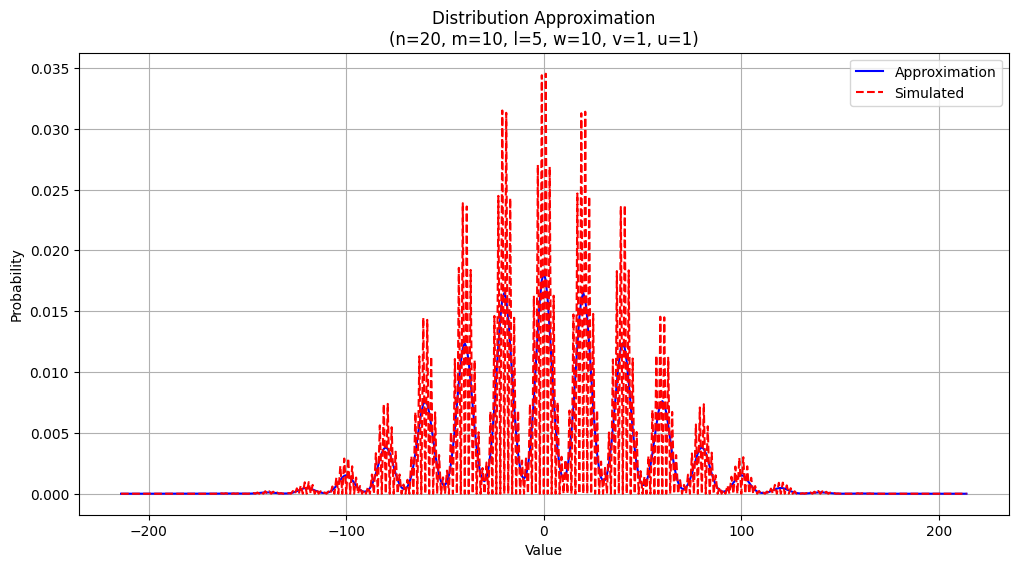

In [37]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from collections import Counter

def approximate_pmf(n, m, l, w, v, u):
    """
    Approximate the PMF by treating it as a binomial convolved with Gaussian noise
    """
    # Variance of the "noise" (v and u components)
    noise_variance = v*v*m + u*u*l
    noise_std = np.sqrt(noise_variance)
    
    # Create the PMF dictionary
    pmf = {}
    
    # Calculate support range similar to before
    k_min = -w*n - int(4*noise_std)  # Add some buffer for the Gaussian tails
    k_max = w*n + int(4*noise_std)
    
    # For each possible value
    for x in range(k_min, k_max + 1):
        prob = 0
        # Sum over all possible values of the w-weighted binomial
        for i in range(n + 1):
            # Probability of getting i heads in the w-weighted binomial
            binom_prob = math.comb(n, i) / 2**n
            # Center of the Gaussian for this binomial outcome
            center = w*(2*i - n)
            # Add contribution from Gaussian centered at this value
            prob += binom_prob * norm.pdf(x, center, noise_std)
            
        if prob > 1e-10:  # Ignore very small probabilities
            pmf[x] = prob
    
    # Normalize to ensure it sums to 1
    total = sum(pmf.values())
    return {k: v/total for k, v in pmf.items()}

def simulate_distribution_three(n, m, l, u, v, w, num_samples=100000):
    """Existing simulation function"""
    x_samples = np.random.binomial(n, 0.5, num_samples)
    y_samples = np.random.binomial(m, 0.5, num_samples)
    z_samples = np.random.binomial(l, 0.5, num_samples)
    
    result = (w*(2*x_samples - n) + 
             v*(2*y_samples - m) + 
             u*(2*z_samples - l))
    
    counts = Counter(result)
    total = sum(counts.values())
    return {k: v/total for k, v in counts.items()}

# Test parameters
n, m, l = 20, 10, 5
w, v, u = 10, 1, 1

# Get both distributions
approx = approximate_pmf(n, m, l, w, v, u)
simulated = simulate_distribution_three(n, m, l, u, v, w, num_samples=1000000)

# Plot comparison
plt.figure(figsize=(12, 6))
k_values = sorted(set(approx.keys()) | set(simulated.keys()))

plt.plot(k_values, [approx.get(k, 0) for k in k_values], 'b-', label='Approximation')
plt.plot(k_values, [simulated.get(k, 0) for k in k_values], 'r--', label='Simulated')
plt.legend()
plt.grid(True)
plt.title(f'Distribution Approximation\n(n={n}, m={m}, l={l}, w={w}, v={v}, u={u})')
plt.xlabel('Value')
plt.ylabel('Probability')

# Print some validation statistics
def get_stats(pmf):
    mean = sum(k*p for k, p in pmf.items())
    var = sum(k*k*p for k, p in pmf.items()) - mean*mean
    return mean, var

mean_approx, var_approx = get_stats(approx)
mean_sim, var_sim = get_stats(simulated)
expected_var = w*w*n + v*v*m + u*u*l

print(f"\nApproximation mean: {mean_approx:.4f}, variance: {var_approx:.4f}")
print(f"Simulated mean: {mean_sim:.4f}, variance: {var_sim:.4f}")
print(f"Expected variance: {expected_var:.4f}")

Approximation mean: -0.0000, variance: 12564.9999
Simulated mean: 0.1293, variance: 12537.3151
Expected variance: 12565.0000

Total Variation distance: 0.500016
KL divergence (D(sim||approx)): 0.693592
Sup diff : 0.008719


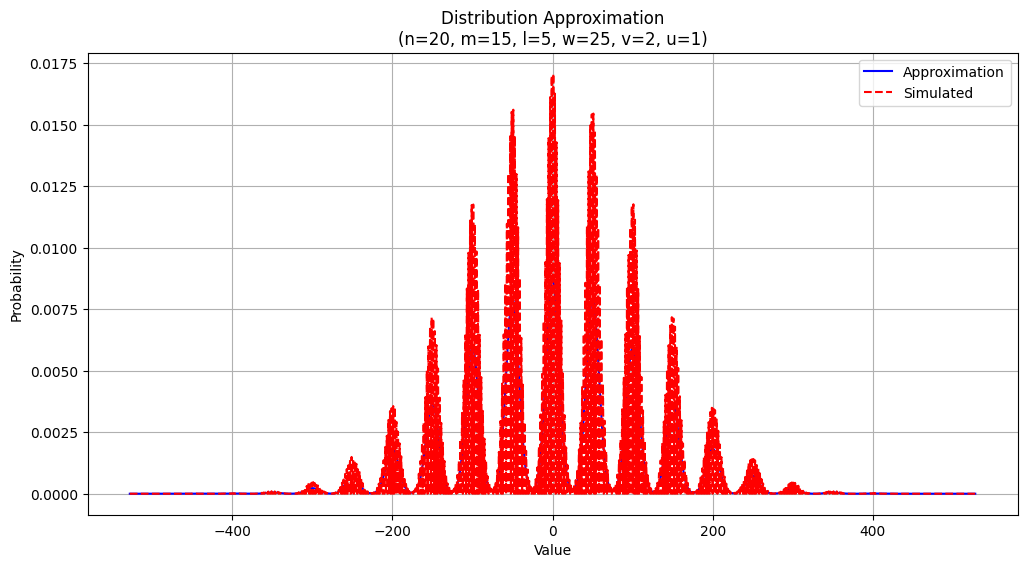

In [41]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from collections import Counter

# [Previous functions remain the same: approximate_pmf, simulate_distribution_three]

def total_variation(p, q):
    """
    Calculate Total Variation distance between two distributions
    p, q: dictionaries mapping values to probabilities
    """
    # Get all possible values
    all_values = set(p.keys()) | set(q.keys())
    
    # Sum |p(x) - q(x)| over all x
    return 0.5 * sum(abs(p.get(x, 0) - q.get(x, 0)) for x in all_values)

def sup_norm(p, q):
    """
    Calculate Total Variation distance between two distributions
    p, q: dictionaries mapping values to probabilities
    """
    # Get all possible values
    all_values = set(p.keys()) | set(q.keys())
    
    # Sum |p(x) - q(x)| over all x
    return max(abs(p.get(x, 0) - q.get(x, 0)) for x in all_values)

def kl_divergence(p, q):
    """
    Calculate KL divergence D(P||Q) between two distributions
    p, q: dictionaries mapping values to probabilities
    """
    # We only need to sum over values where p is positive
    kl = 0
    for x in p.keys():
        px = p[x]
        qx = q.get(x, 0)
        if px > 0 and qx > 0:  # Avoid log(0)
            kl += px * np.log(px / qx)
    return kl

# Test parameters
n, m, l = 20, 15, 5
w, v, u = 25, 2, 1

# Get both distributions
approx = approximate_pmf(n, m, l, w, v, u)
simulated = simulate_distribution_three(n, m, l, u, v, w, num_samples=1000000)

# Plot comparison
plt.figure(figsize=(12, 6))
k_values = sorted(set(approx.keys()) | set(simulated.keys()))

plt.plot(k_values, [approx.get(k, 0) for k in k_values], 'b-', label='Approximation')
plt.plot(k_values, [simulated.get(k, 0) for k in k_values], 'r--', label='Simulated')
plt.legend()
plt.grid(True)
plt.title(f'Distribution Approximation\n(n={n}, m={m}, l={l}, w={w}, v={v}, u={u})')
plt.xlabel('Value')
plt.ylabel('Probability')

# Calculate and print statistics
mean_approx, var_approx = get_stats(approx)
mean_sim, var_sim = get_stats(simulated)
expected_var = w*w*n + v*v*m + u*u*l

print(f"Approximation mean: {mean_approx:.4f}, variance: {var_approx:.4f}")
print(f"Simulated mean: {mean_sim:.4f}, variance: {var_sim:.4f}")
print(f"Expected variance: {expected_var:.4f}")

# Calculate and print statistical distances
tv_dist = total_variation(approx, simulated)
kl_div = kl_divergence(simulated, approx)  # Using simulated as P, approx as Q
max_diff = sup_norm(simulated, approx)

print(f"\nTotal Variation distance: {tv_dist:.6f}")
print(f"KL divergence (D(sim||approx)): {kl_div:.6f}")
print(f"Sup diff : {max_diff:.6f}")